In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import csv

def find_dicom_images_in_folder(folder_path,folder_path2):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths.append([os.path.join(root, file), os.path.basename(root)])
    i=0
    for root, dirs, files in os.walk(folder_path2):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths[i].append(os.path.join(root, file))
                i+=1
    return image_paths

def save_paths_to_csv(dicom_paths, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Image_Path","Label", "Mask_Path"])
        for path,path2, label in dicom_paths:
            writer.writerow([path,path2, label])

folder_path = "/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/term2 (1)/7_data_png"
mask_path="/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/term2 (1)/7_mask_data_png"
dicom_paths = find_dicom_images_in_folder(folder_path,mask_path)
if dicom_paths:
    csv_filename ="data_kayıt.csv"
    save_paths_to_csv(dicom_paths, csv_filename)
    print(f"{len(dicom_paths)} DICOM dosyası CSV dosyasına kaydedildi.")
else:
    print("Belirtilen klasörde DICOM dosyası bulunamadı.")



1488 DICOM dosyası CSV dosyasına kaydedildi.


In [3]:
import pandas as pd
df=pd.read_csv("data_kayıt.csv")
df.head()

,Image_Path,Label,Mask_Path
0,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
1,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
2,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
3,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
4,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...


In [ ]:
df.Label.value_counts()

ground_glass     390
fibrosis         386
micronodules     274
consolidation    183
healthy          100
reticulation      89
emphysema         66
Name: Label, dtype: int64

In [4]:

reticulation_df=df[df["Label"]=="reticulation"]
emphysema_df=df[df["Label"]=="emphysema"]
df = df[(df["Label"] != "reticulation") & (df["Label"] != "emphysema")]


In [ ]:
print(df.isnull().sum())
print(df["Image_Path"].apply(type).value_counts())
print(df["Mask_Path"].apply(type).value_counts())
print(df["Label"].apply(type).value_counts())


Image_Path    0
Label         0
Mask_Path     0
dtype: int64
<class 'str'>    1333
Name: Image_Path, dtype: int64
<class 'str'>    1333
Name: Mask_Path, dtype: int64
<class 'str'>    1333
Name: Label, dtype: int64


In [5]:
df["Image_Path"]=df["Image_Path"].astype(str)
df["Mask_Path"]=df["Mask_Path"].astype(str)
df["Label"]=df["Label"].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 0 to 1332
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  1333 non-null   object
 1   Label       1333 non-null   object
 2   Mask_Path   1333 non-null   object
dtypes: object(3)
memory usage: 41.7+ KB


In [6]:
import tensorflow
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
df.Label=df.Label.replace({"ground_glass":0, "fibrosis":1 ,"micronodules":2 ,"consolidation":3,"healthy":4})
df.Label = df.Label.astype(str)
datagen = ImageDataGenerator()

target_size=(128,128)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(train_df.head())
# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Mask_Path",
    y_col="Label",
    batch_size=16,
    seed=42,
    class_mode='sparse',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Mask_Path",
    y_col="Label",
    batch_size=16,
    seed=42,
    class_mode='sparse',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)

                                             Image_Path Label  \
1280  /content/drive/MyDrive/Colab Notebooks/Pulmona...     4   
1110  /content/drive/MyDrive/Colab Notebooks/Pulmona...     3   
966   /content/drive/MyDrive/Colab Notebooks/Pulmona...     2   
598   /content/drive/MyDrive/Colab Notebooks/Pulmona...     1   
170   /content/drive/MyDrive/Colab Notebooks/Pulmona...     0   

                                              Mask_Path  
1280  /content/drive/MyDrive/Colab Notebooks/Pulmona...  
1110  /content/drive/MyDrive/Colab Notebooks/Pulmona...  
966   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
598   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
170   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
Found 1066 validated image filenames belonging to 5 classes.
Found 267 validated image filenames belonging to 5 classes.


In [7]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
base_model=InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

219055592/219055592 [==============================] - 7s 0us/step


In [8]:
from keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(train_data_generator,
                    steps_per_epoch=1066   //16,
                    epochs = 20,
                    validation_data=val_data_generator,
                    validation_steps= 267 // 16,
                    callbacks = [callback])

Epoch 1/20
66/66 [==============================] - 560s 8s/step - loss: 1.3729 - accuracy: 0.5105 - val_loss: 4.5324 - val_accuracy: 0.3047
Epoch 2/20
66/66 [==============================] - 465s 7s/step - loss: 0.7789 - accuracy: 0.7162 - val_loss: 2.8592 - val_accuracy: 0.1836
Epoch 3/20
66/66 [==============================] - 445s 7s/step - loss: 0.4930 - accuracy: 0.8343 - val_loss: 1.2780 - val_accuracy: 0.4961
Epoch 4/20
66/66 [==============================] - 442s 7s/step - loss: 0.3720 - accuracy: 0.8876 - val_loss: 0.6603 - val_accuracy: 0.7617
Epoch 5/20
66/66 [==============================] - 441s 7s/step - loss: 0.3262 - accuracy: 0.8933 - val_loss: 0.5720 - val_accuracy: 0.7891
Epoch 6/20
66/66 [==============================] - 468s 7s/step - loss: 0.2153 - accuracy: 0.9248 - val_loss: 1.1981 - val_accuracy: 0.7227
Epoch 7/20
66/66 [==============================] - 451s 7s/step - loss: 0.2273 - accuracy: 0.9276 - val_loss: 0.5989 - val_accuracy: 0.8477
Epoch 8/20
66

17/17 [==============================] - 30s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.87      0.92        82
           1       0.88      0.82      0.85        79
           2       0.72      0.87      0.79        45
           3       0.97      0.87      0.92        38
           4       0.61      0.87      0.71        23

    accuracy                           0.85       267
   macro avg       0.83      0.86      0.84       267
weighted avg       0.87      0.85      0.86       267



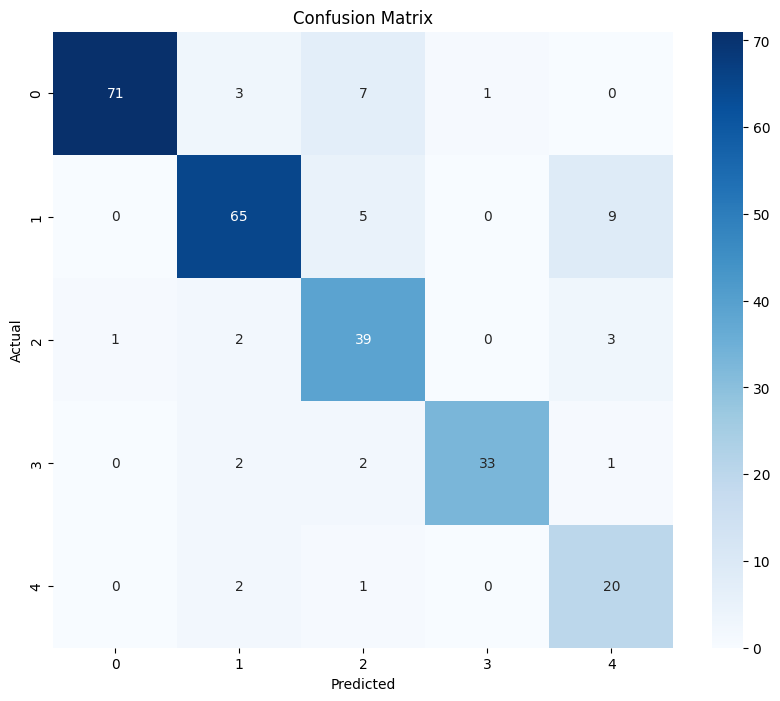

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tahminleri al (modeliniz ve data generator'ınızın class_mode'u 'categorical' ise bu şekilde çalışır)
val_pred = model.predict(val_data_generator, steps=np.ceil(val_data_generator.samples / val_data_generator.batch_size))
val_pred_classes = np.argmax(val_pred, axis=1)

# Gerçek etiketleri al
val_labels = val_data_generator.classes

# Classification report
print(classification_report(val_labels, val_pred_classes, target_names=list(val_data_generator.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(val_labels, val_pred_classes)

# Confusion matrix'i renkli olarak çizdir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data_generator.class_indices, yticklabels=val_data_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()